In [11]:
import os
import mne
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs, seed_target_indices

from settings import *

from helper_functions import save_figure

Let's load some general needed information

In [12]:
epoch_folder = paths['epochs_folder']
plot_folder = paths['plots_folder']

In [13]:
excluded_chans = ['EMG_L', 'EMG_R']

## Let's load all needed epochs

In [4]:
all_subject_epochs = []
for file in os.listdir(epoch_folder):
    subj_id = file.split('_')[-1].split('-')[0]
    if not file.startswith('epochs_w_cluster_annotations') or int(subj_id) in omitted_after_clustering or int(
            subj_id) in omitted_other:
        continue
    all_subject_epochs.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=True))

Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\epochs_w_cluster_annotations_39489-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4998.53 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
594 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\epochs_w_cluster_annotations_39508-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4998.53 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
389 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\Olle de Jong\Documents\MSc Biology\rp2\rp2_data\resting_state\output\epochs\epochs_w_cluster_annotations_78211-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00

## Regular connectivity analysis

Let's first define a function that allows us to compute the connectivity using a provided method/metric

In [25]:
def compute_con(epochs, method, fmin=0, fmax=100):
    # Compute spectral connectivity
    con = spectral_connectivity_epochs(
        epochs, method=method, mode='multitaper', sfreq=epochs.info['sfreq'],
        fmin=fmin, fmax=fmax, faverage=True, verbose='WARNING', gc_n_lags=40)
    return con.get_data(output='dense')

And a function that computes a dataframe holding the connectivity for all the subject's epochs.

In [16]:
def connectivity_df(subject_epoch_objects, picked_ids, method):
    print(f'Computing {method} connectivity for subjects:\n {picked_ids}')
    results_df = pd.DataFrame()

    # per subject, calculate the given measure for all epochs
    for subject_epochs in subject_epoch_objects:
        subject_id = int(subject_epochs.metadata['animal_id'].iloc[0])
        if subject_id not in picked_ids:
            print(f'Subject {subject_id} was not picked, skipping..')
            continue
        if int(subject_id) in omitted_after_clustering or int(subject_id) in omitted_other:
            print(f'Skipping {subject_id}..')
            continue
            
        genotype = subject_epochs.metadata['genotype'].iloc[0]
        
        # get only resting-state epochs
        annotations = cluster_annotations[int(subject_id)]
        resting_epochs = subject_epochs[subject_epochs.metadata["cluster"] == annotations['rest']]
        resting_epochs = resting_epochs.drop_channels(excluded_chans)
    
        # compute the given connectivity measure for every frequency band
        for band_name, (fmin, fmax) in freq_bands_eeg.items():
            # compute the connectivity using the provided method
            if fmin == 1: fmin = 1.01
            con = compute_con(resting_epochs, method, fmin, fmax)
            
            # loop through every channel combination
            for i in range(con.shape[1]):
                for j in range(i+1, con.shape[0]):
                    if subject_id in low_qual_chans.keys():
                        if resting_epochs.ch_names[i] in low_qual_chans[subject_id] or resting_epochs.ch_names[j] in low_qual_chans[subject_id]:
                            continue
                    # add the data
                    results_df = pd.concat([results_df, pd.DataFrame({
                        'con' : con[j, i, 0],
                        'node1' : resting_epochs.ch_names[i],
                        'node2' : resting_epochs.ch_names[j],
                        'band' : band_name,
                        'subject_id': subject_id,
                        'genotype': genotype
                    }, index=[0])], ignore_index=True)
    print(f'Done computing {method} connectivity.')
    return results_df

And also a function that allows us to generate a heatmap of the connectivity per channel combination

In [17]:
def generate_con_heatmap(df, freq_band, cmap, fig_title='', method='', ax=None):
    # subset the data for a given frequency band
    filtered_df = df[df['band'] == freq_band]

    # generate pivot table with mean 'method' values
    pivot_table = filtered_df.pivot_table(index='node1', columns='node2', values='con', aggfunc='mean')

    # make table symmetric by filling missing values
    pivot_table = pivot_table.combine_first(pivot_table.T)

    # set diagonal and upper triangle values to NaN, this way we still plot all data
    for i in range(pivot_table.shape[0]):
        for j in range(i, pivot_table.shape[1]):
            pivot_table.iat[i, j] = np.nan

    fig = sns.heatmap(pivot_table, cmap=cmap, annot=True, fmt=".2f", vmin=0, vmax=1, ax=ax, square=True, cbar_kws={'shrink': 0.75})
    fig.set_title(fig_title)

    cbar = fig.collections[0].colorbar
    cbar.set_label(f'Mean {method}', fontsize=12)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

And a function that allows us to plot the connectivity differences between the two genotypes for the 4 channels of interest

In [28]:
def generate_grid_plot_wt_vs_ko(data, method, cmap='flare'):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(24, 10))
    
    freq_band_names = freq_bands_eeg.keys()
    genotypes = data['genotype'].unique()
    
    # loop through genotypes
    for i, genotype in enumerate(genotypes):
        genotype_data = data[data['genotype'] == genotype]
        for j, band in enumerate(freq_band_names):
            generate_con_heatmap(genotype_data, band, cmap=cmap, fig_title=f'{genotype} - {band} Band', method=method, ax=ax[i, j])
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.25, hspace=-0.1)
    save_figure(os.path.join(plot_folder, f"resting_state/connectivity/{method}_wt_vs_ko.pdf"))

Lastly a function that allows us to generate barplots of the connectivity measures

In [29]:
def generate_barplots(data, method):
    combinations = data['node1'] + '-' + data['node2']
    unique_combinations = combinations.unique()
    
    fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 15), sharey=True, sharex=True)
    axs = axs.ravel()
    
    for i, combination in enumerate(unique_combinations):
        # subset the data
        chan1, chan2 = combination.split('-')
        data_subset = data[(data['node1'] == chan1) & (data['node2'] == chan2)]
        palette = {'DRD2-WT': '#427C99', 'DRD2-KO': '#AF5541'}
        
        sns.barplot(data=data_subset, x="band", y="con", hue="genotype", palette=palette, hue_order=["DRD2-WT", "DRD2-KO"], ax=axs[i], errorbar=None)
        sns.stripplot(data=data_subset, x="band", y="con", hue="genotype", palette='dark:black', hue_order=["DRD2-WT", "DRD2-KO"], alpha=0.4, dodge=True, legend=False, ax=axs[i])
        
        axs[i].set_title(f"Connectivity of {chan1} and {chan2} ({method.upper()})")
        axs[i].set_xlabel("Frequency band")
        axs[i].set_ylabel(f"Connectivity ({method.upper()})")
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    save_figure(os.path.join(plot_folder, f"resting_state/connectivity/{method}_barplot_grid.pdf"))

### Testing on a single subject (30958)

#### Phase Lag Index exploration

In [41]:
epochs_39508 = all_subject_epochs[7].copy()
epochs_39508.drop_channels(excluded_chans)
epochs_39508 = epochs_39508[epochs_39508.metadata['cluster'] == cluster_annotations[39508]['rest']]
epochs_39508.info['ch_names']

['OFC_R', 'OFC_L', 'CG', 'STR_R']

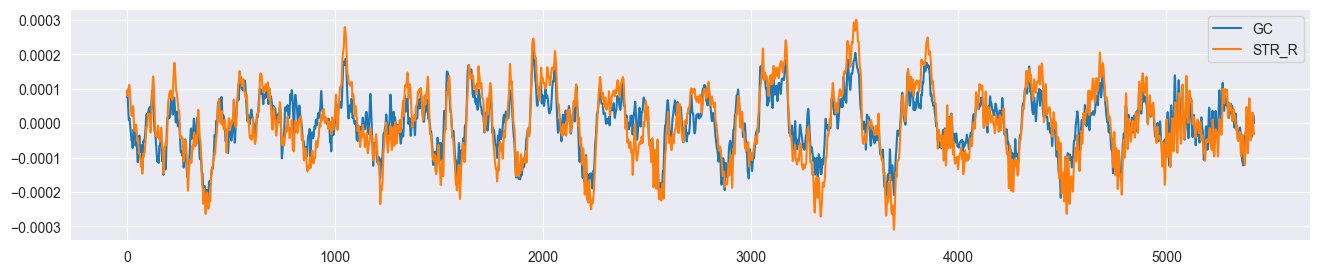

In [71]:
fig = plt.figure(figsize=(16, 3))
plt.plot(epochs_39508[22].get_data(picks='CG')[0,0,:], label='GC')
plt.plot(epochs_39508[22].get_data(picks='STR_R')[0,0,:], label='STR_R')
plt.legend()

Visually, it doesn't seem like one signal is leading or lagging the other.

In [69]:
seeds = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
targets = [idx for idx, ch_info in enumerate(['OFC_R', 'OFC_L', 'CG', 'STR_R'])]
indices = seed_target_indices(seeds, targets)
print(f'Bi-variate indexes used for pairwise connectivity calculations:\n {indices}')

# calculate dpli for one specific epoch
dpli_test = spectral_connectivity_epochs(
    epochs_39508[22], indices=indices, sfreq=epochs_39508.info['sfreq'], method="dpli", fmin=1, fmax=100
)

# report some stuff
print(f'\nShape of the dpli output: {dpli_test.get_data(output="dense").shape}')
print(f'\nLength of the frequency array (holds at which the dPLI is calculated): {len(dpli_test.freqs)}')
print(f'\nThe dPLI output:\n {dpli_test.get_data(output="dense")}')

Bi-variate indexes used for pairwise connectivity calculations:
 (array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]), array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]))

Shape of the dpli output: (4, 4, 495)

Length of the frequency array (holds at which the dPLI is calculated): 495

The dPLI output:
 [[[0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [1.  1.  1.  ... 1.  1.  1. ]
  [1.  1.  0.  ... 1.  1.  1. ]
  [0.  0.  0.  ... 1.  1.  1. ]]

 [[0.  0.  0.  ... 0.  0.  0. ]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [0.  0.  0.  ... 1.  1.  1. ]
  [1.  1.  0.  ... 1.  1.  1. ]]

 [[0.  0.  1.  ... 0.  0.  0. ]
  [1.  1.  1.  ... 0.  0.  0. ]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]
  [1.  0.  0.  ... 0.  1.  1. ]]

 [[1.  1.  1.  ... 0.  0.  0. ]
  [0.  0.  1.  ... 0.  0.  0. ]
  [0.  1.  1.  ... 1.  0.  0. ]
  [0.5 0.5 0.5 ... 0.5 0.5 0.5]]]


/var/folders/rf/xrxwkkr96qq6kyy5jfx9hvgw0000gn/T/ipykernel_3451/1119890008.py:5: RuntimeWarning: fmin=1.000 Hz corresponds to 4.999 < 5 cycles based on the epoch length 4.999 sec, need at least 5.000 sec epochs or fmin=1.000. Spectrum estimate will be unreliable.
  dpli_test = spectral_connectivity_epochs(


Above, we calculated the dpli connectivity measure for one specific epoch. Because we put 'OFC_R', 'OFC_L', 'CG', 'STR_R' in as indices, we get 4x4 = 16 dPLI values per chan to chan comparison. However, we receive a dPLI value per frequency, here resulting in 495 values, which describe the connectivity a different frequencies (see len(dpli_test.freqs))

As we compared the GC and STR_R channels of epoch at index 22 of the resting epochs of 39508, we grab the dPLI values for that specific comparison. Note: this is both from CG to STR_R, but also the other way around. Then we average the dPLI for both.

In [73]:
print(f'Mean dPLI for CG --> STR_R:  {np.average(dpli_test.get_data(output="dense")[2,3,:])}')
print(f'Mean dPLI for STR_R --> CG:  {np.average(dpli_test.get_data(output="dense")[3,2,:])}')

Mean dPLI for CG <--> STR_R:  0.7353535353535353
Mean dPLI for STR_R <--> CG:  0.26464646464646463


We can, from these, observe that they are each others opposites, which makes sense, as we calculate the **directed** phase-lag index here. If one leads or lags the other, the score of the reverse is gonna be the opposite. Note; the dPLI ranges from 0 to 1.

Now, how do we interpret this?

The reference (first provided signal) is lagging the other signal if dPLI is between 0 and 0.5, and the reference signal is leading the other signal is the dPLI is between 0.5 and 1.0.

So, the CG is leading the STR_R signal, or, the STR_R is lagging the CG signal.


#### Granger Causality exploration

In [222]:
# parietal sensors
signals_a = [
    idx
    for idx, ch_info in enumerate(epochs_39508.info["chs"])
    if ch_info["ch_name"] == "OFC_L" # TODO can add condition for channel here
]
# occipital sensors
signals_b = [
    idx
    for idx, ch_info in enumerate(epochs_39508.info["chs"])
    if ch_info["ch_name"] == "CG"
]

indices_ab = (np.array([signals_a]), np.array([signals_b]))  # A => B
indices_ba = (np.array([signals_b]), np.array([signals_a]))  # B => A
print(indices_ab)
print(indices_ba)

(array([[1]]), array([[2]]))
(array([[2]]), array([[1]]))


In [223]:
gc_ab = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc"],
    indices=indices_ab,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
)  # A => B
gc_ba = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc"],
    indices=indices_ba,
    fmin=5,
    fmax=30,
    gc_n_lags=20,
)  # B => A
freqs = gc_ab.freqs
print(gc_ab.shape)
print(gc_ab)

(1, 125)
<SpectralConnectivity | freq : [5.000549, 29.803273], , nave : 1, nodes, n_estimated : 4, 1, ~177 kB>


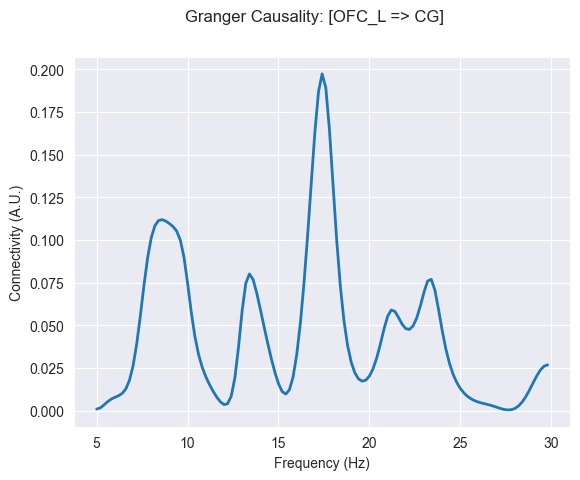

In [224]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ab.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Granger Causality: [OFC_L => CG]")
plt.show()

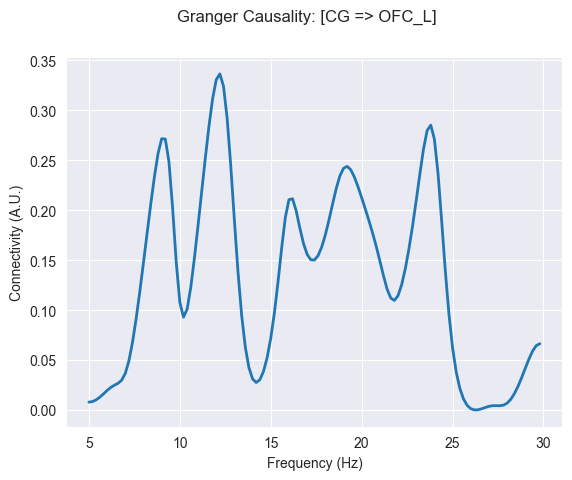

In [225]:
fig, axis = plt.subplots(1, 1)
axis.plot(freqs, gc_ba.get_data()[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Granger Causality: [CG => OFC_L]")
plt.show()

Text(0.5, 0.98, 'Net Granger Causality: [OFC_L => CG] - [CG => OFC_L]')

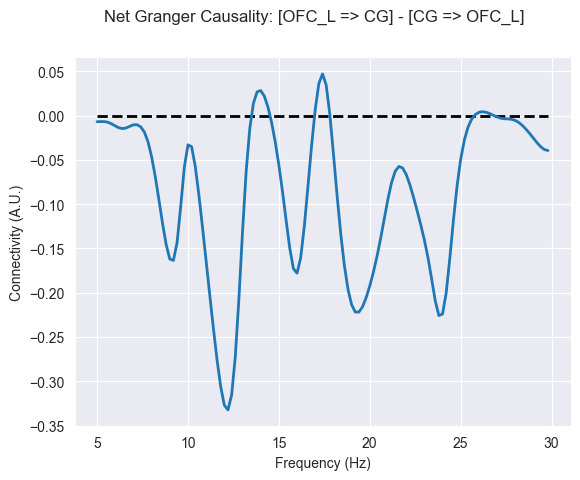

In [226]:
net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]

fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, net_gc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("Net Granger Causality: [OFC_L => CG] - [CG => OFC_L]")

By subtracting the flow of information from CG to OFC_L from the flow of information of the reverse we get the net granger causality.

This tells us, that for this specific epoch, there's more information flow from the Cingulate Cortex to the left Orbitalfrontal Cortex.

#### Time-traversed Granger Causality

In [227]:
# compute GC on time-reversed signals
gc_tr_ab = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc_tr"],
    indices=indices_ab,
    fmin=5,
    fmax=30,
    gc_n_lags=60,
)  # TR[A => B]
gc_tr_ba = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc_tr"],
    indices=indices_ba,
    fmin=5,
    fmax=30,
    gc_n_lags=60,
)  # TR[B => A]

# compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()

# compute TRGC
trgc = net_gc - net_gc_tr

Plot the net time-traversed GC

Text(0.5, 0.98, 'TRGC: net[OFC_L => CG] - net time-reversed[CG => OFC_L]')

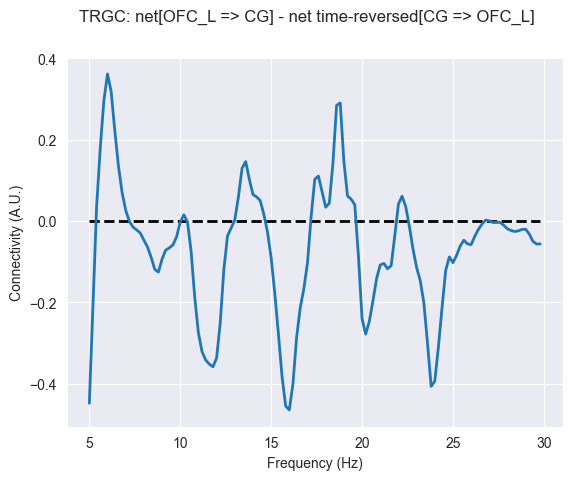

In [228]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, trgc[0], linewidth=2)
axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle("TRGC: net[OFC_L => CG] - net time-reversed[CG => OFC_L]")

Let's compute the net time-reversed granger causality for the frequencies 0 through 100 Hz.

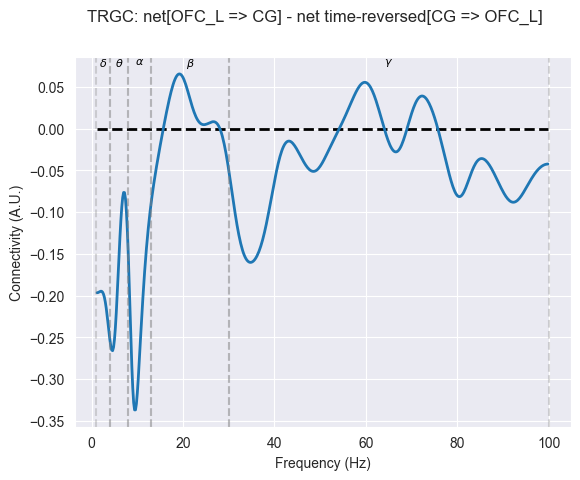

In [230]:
gc_ab = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc"],
    indices=indices_ab,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
)  # A => B
gc_ba = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc"],
    indices=indices_ba,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
)  # B => A
freqs = gc_ab.freqs
net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
# compute GC on time-reversed signals
gc_tr_ab = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc_tr"],
    indices=indices_ab,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
)  # TR[A => B]
gc_tr_ba = spectral_connectivity_epochs(
    epochs_39508[22],
    method=["gc_tr"],
    indices=indices_ba,
    fmin=1.01,
    fmax=100,
    gc_n_lags=20,
)  # TR[B => A]

# compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()

# compute TRGC
trgc = net_gc - net_gc_tr

fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, trgc[0], linewidth=2)
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[OFC_L => CG] - net time-reversed[CG => OFC_L]")
plt.show()

### Resting-state, DRD2-KO vs DRD2-WT

First, let's pick an equal amount of WT and KO subjects (randomly)


In [20]:
wt_ids = [sub_obj.metadata["animal_id"].iloc[0] for sub_obj in all_subject_epochs if sub_obj.metadata["genotype"].iloc[0] == "DRD2-WT"]
ko_ids = [sub_obj.metadata["animal_id"].iloc[0] for sub_obj in all_subject_epochs if sub_obj.metadata["genotype"].iloc[0] == "DRD2-KO"]

# remove 81193 (KO), 39489 (KO), and 80625 (KO) because they have (a) low quality OFC channel(s) anyway ( see low_qual_chans variable )
ko_ids = [el for el in ko_ids if el not in low_qual_chans.keys()]

# there's more ko subjects than wts, so we sample an equal amount from the ko's
random.seed(40)  # for reproducibility
picked_ids = wt_ids + random.sample(ko_ids, len(wt_ids))
picked_ids = [int(idx) for idx in picked_ids]
print(picked_ids)
print(len(picked_ids))

[39508, 79602, 80620, 80630, 81207, 81217, 81175, 81193, 39489, 78211, 78227, 80625]
12


In [22]:
picked_ids = [int(sub_obj.metadata["animal_id"].iloc[0]) for sub_obj in all_subject_epochs]

[39489,
 39508,
 78211,
 78227,
 79592,
 79593,
 79602,
 79604,
 80620,
 80625,
 80630,
 81175,
 81193,
 81207,
 81217,
 81218]

#### Coherence (coh)

In [26]:
coh = connectivity_df(all_subject_epochs, picked_ids, "coh")
coh.head()

Computing coh connectivity for subjects:
 [39489, 39508, 78211, 78227, 79592, 79593, 79602, 79604, 80620, 80625, 80630, 81175, 81193, 81207, 81217, 81218]
Done computing coh connectivity.


,con,node1,node2,band,subject_id,genotype
0,0.778801,OFC_L,CG,$\delta$,39489,DRD2-KO
1,0.420275,OFC_L,STR_R,$\delta$,39489,DRD2-KO
2,0.161719,OFC_L,S1_L,$\delta$,39489,DRD2-KO
3,0.353221,OFC_L,S1_R,$\delta$,39489,DRD2-KO
4,0.249633,OFC_L,V1_R,$\delta$,39489,DRD2-KO


In [27]:
print(f'Lengths of WT and KO connectivity dataframes, respectively: {coh[coh.genotype == "DRD2-WT"].shape} and {coh[coh.genotype == "DRD2-KO"].shape}')

Lengths of WT and KO connectivity dataframes, respectively: (630, 6) and (935, 6)


If there's inequality in the number of rows, that is probably due too some channels being skipped (see 'low_qual_chans' variable)

In [30]:
generate_grid_plot_wt_vs_ko(coh, 'coh')

In [31]:
generate_barplots(coh, 'coh')

#### Phase Lag Index (PLI)

In [32]:
pli = connectivity_df(all_subject_epochs, picked_ids, "pli")
pli.head()

Computing pli connectivity for subjects:
 [39489, 39508, 78211, 78227, 79592, 79593, 79602, 79604, 80620, 80625, 80630, 81175, 81193, 81207, 81217, 81218]
Done computing pli connectivity.


,con,node1,node2,band,subject_id,genotype
0,0.342857,OFC_L,CG,$\delta$,39489,DRD2-KO
1,0.322449,OFC_L,STR_R,$\delta$,39489,DRD2-KO
2,0.089796,OFC_L,S1_L,$\delta$,39489,DRD2-KO
3,0.240816,OFC_L,S1_R,$\delta$,39489,DRD2-KO
4,0.077551,OFC_L,V1_R,$\delta$,39489,DRD2-KO


In [33]:
print(f'Lengths of WT and KO connectivity dataframes, respectively: {pli[pli.genotype == "DRD2-WT"].shape} and {pli[pli.genotype == "DRD2-KO"].shape}')

Lengths of WT and KO connectivity dataframes, respectively: (630, 6) and (935, 6)


We need to account for unequal sample size to make the 

In [34]:
generate_grid_plot_wt_vs_ko(pli, 'pli')

In [35]:
generate_barplots(pli, 'pli')

#### Directed Phase Lag Index (dPLI)

In [36]:
dpli = connectivity_df(all_subject_epochs, picked_ids, "dpli")
dpli.head()

Computing dpli connectivity for subjects:
 [39489, 39508, 78211, 78227, 79592, 79593, 79602, 79604, 80620, 80625, 80630, 81175, 81193, 81207, 81217, 81218]
Done computing dpli connectivity.


,con,node1,node2,band,subject_id,genotype
0,0.671429,OFC_L,CG,$\delta$,39489,DRD2-KO
1,0.661224,OFC_L,STR_R,$\delta$,39489,DRD2-KO
2,0.522449,OFC_L,S1_L,$\delta$,39489,DRD2-KO
3,0.606122,OFC_L,S1_R,$\delta$,39489,DRD2-KO
4,0.481633,OFC_L,V1_R,$\delta$,39489,DRD2-KO


In [37]:
generate_grid_plot_wt_vs_ko(dpli, 'dpli')

When it comes to dPLI. The reference (first provided signal) is lagging the other signal if dPLI is between 0 and 0.5, and the reference signal is leading the other signal is the dPLI is between 0.5 and 1.0.

In the heatmaps we create here, the first provided signal is always on the 

In [38]:
generate_barplots(dpli, 'dpli')

#### Weighted Phase Lag Index (wPLI)

In [39]:
wpli = connectivity_df(all_subject_epochs, picked_ids, "wpli")
wpli.head()

Computing wpli connectivity for subjects:
 [39489, 39508, 78211, 78227, 79592, 79593, 79602, 79604, 80620, 80625, 80630, 81175, 81193, 81207, 81217, 81218]
Done computing wpli connectivity.


,con,node1,node2,band,subject_id,genotype
0,0.519100,OFC_L,CG,$\delta$,39489,DRD2-KO
1,0.544197,OFC_L,STR_R,$\delta$,39489,DRD2-KO
2,0.145952,OFC_L,S1_L,$\delta$,39489,DRD2-KO
3,0.305916,OFC_L,S1_R,$\delta$,39489,DRD2-KO
4,0.232332,OFC_L,V1_R,$\delta$,39489,DRD2-KO


In [40]:
generate_grid_plot_wt_vs_ko(wpli, 'wpli')

In [41]:
generate_barplots(wpli, 'wpli')

#### Debiased estimator of squared WPLI (wPLI2 debiased)

In [42]:
wpli2 = connectivity_df(all_subject_epochs, picked_ids, "wpli2_debiased")
wpli2.head()

Computing wpli2_debiased connectivity for subjects:
 [39489, 39508, 78211, 78227, 79592, 79593, 79602, 79604, 80620, 80625, 80630, 81175, 81193, 81207, 81217, 81218]
Done computing wpli2_debiased connectivity.


,con,node1,node2,band,subject_id,genotype
0,0.244510,OFC_L,CG,$\delta$,39489,DRD2-KO
1,0.288025,OFC_L,STR_R,$\delta$,39489,DRD2-KO
2,-0.052481,OFC_L,S1_L,$\delta$,39489,DRD2-KO
3,0.064852,OFC_L,S1_R,$\delta$,39489,DRD2-KO
4,-0.001550,OFC_L,V1_R,$\delta$,39489,DRD2-KO


In [43]:
generate_grid_plot_wt_vs_ko(wpli2, 'wpli2_debiased')

In [44]:
generate_barplots(wpli2, 'wpli2_debiased')

#### Pairwise Phase Consistency (PPC)

In [45]:
ppc = connectivity_df(all_subject_epochs, picked_ids, "ppc")
ppc.head()

Computing ppc connectivity for subjects:
 [39489, 39508, 78211, 78227, 79592, 79593, 79602, 79604, 80620, 80625, 80630, 81175, 81193, 81207, 81217, 81218]
Done computing ppc connectivity.


,con,node1,node2,band,subject_id,genotype
0,0.921011,OFC_L,CG,$\delta$,39489,DRD2-KO
1,0.529694,OFC_L,STR_R,$\delta$,39489,DRD2-KO
2,0.063058,OFC_L,S1_L,$\delta$,39489,DRD2-KO
3,0.392414,OFC_L,S1_R,$\delta$,39489,DRD2-KO
4,0.076546,OFC_L,V1_R,$\delta$,39489,DRD2-KO


In [46]:
generate_grid_plot_wt_vs_ko(ppc, 'ppc')

In [47]:
generate_barplots(ppc, 'ppc')

### Granger Causality between brain-regions; WT vs. KO comparison

First, let's define two functions that allow us to compute the time-reversed Granger Causality between two electrodes.

In [5]:
def compute_indices(subject_epochs, channel_a, channel_b):
    signals_a = [
        idx
        for idx, ch_info in enumerate(subject_epochs.info["chs"])
        if ch_info["ch_name"] == channel_a
    ]
    # occipital sensors
    signals_b = [
        idx
        for idx, ch_info in enumerate(subject_epochs.info["chs"])
        if ch_info["ch_name"] == channel_b
    ]
    
    indices_ab = (np.array([signals_a]), np.array([signals_b]))  # A => B
    indices_ba = (np.array([signals_b]), np.array([signals_a]))  # B => A
    
    return indices_ab, indices_ba

In [8]:
def get_tr_gc(all_subject_epochs, picked_ids, channel_a, channel_b):
    wt_trgcs, ko_trgcs = [], []
    
    for subject_epochs in all_subject_epochs:
        subject_id = subject_epochs.metadata['animal_id'].iloc[0]
        genotype = subject_epochs.metadata['genotype'].iloc[0]
        
        # check if we want to compute for this subject/animal
        if subject_id not in picked_ids:
            print(f'Subject {subject_id} was not picked, skipping..')
            continue
        if int(subject_id) in omitted_after_clustering or int(subject_id) in omitted_other:
            print(f'Skipping {subject_id}..')
            continue
            
        indices_ab, indices_ba = compute_indices(subject_epochs, channel_a, channel_b)
            
        annotations = cluster_annotations[int(subject_id)]
        resting_epochs = subject_epochs[subject_epochs.metadata["cluster"] == annotations['rest']]
        resting_epochs = resting_epochs.drop_channels(excluded_chans)
        
        gc_ab = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc"],
            indices=indices_ab,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # A => B
        gc_ba = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc"],
            indices=indices_ba,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # B => A
        freqs = gc_ab.freqs
        net_gc = gc_ab.get_data() - gc_ba.get_data()  # [A => B] - [B => A]
        # compute GC on time-reversed signals
        gc_tr_ab = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc_tr"],
            indices=indices_ab,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # TR[A => B]
        gc_tr_ba = spectral_connectivity_epochs(
            resting_epochs,
            method=["gc_tr"],
            indices=indices_ba,
            fmin=1.01,
            fmax=100,
            gc_n_lags=20,
            verbose='WARNING'
        )  # TR[B => A]
        
        # compute net GC on time-reversed signals (TR[A => B] - TR[B => A])
        net_gc_tr = gc_tr_ab.get_data() - gc_tr_ba.get_data()
        
        # compute TRGC
        trgc = net_gc - net_gc_tr
        
        wt_trgcs.append(trgc) if genotype == "DRD2-WT" else ko_trgcs.append(trgc)
        
    return freqs, wt_trgcs, ko_trgcs

Let's compute the data for the channels OFC_L and CG for all subjects, and split the data into WT and KO resting-state epoch TR-GC

In [9]:
freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, picked_ids, "OFC_L", "CG")

To inspect the variation between WT subjects and between KO subjects, let's create a grid plot of the individual TR GC traces

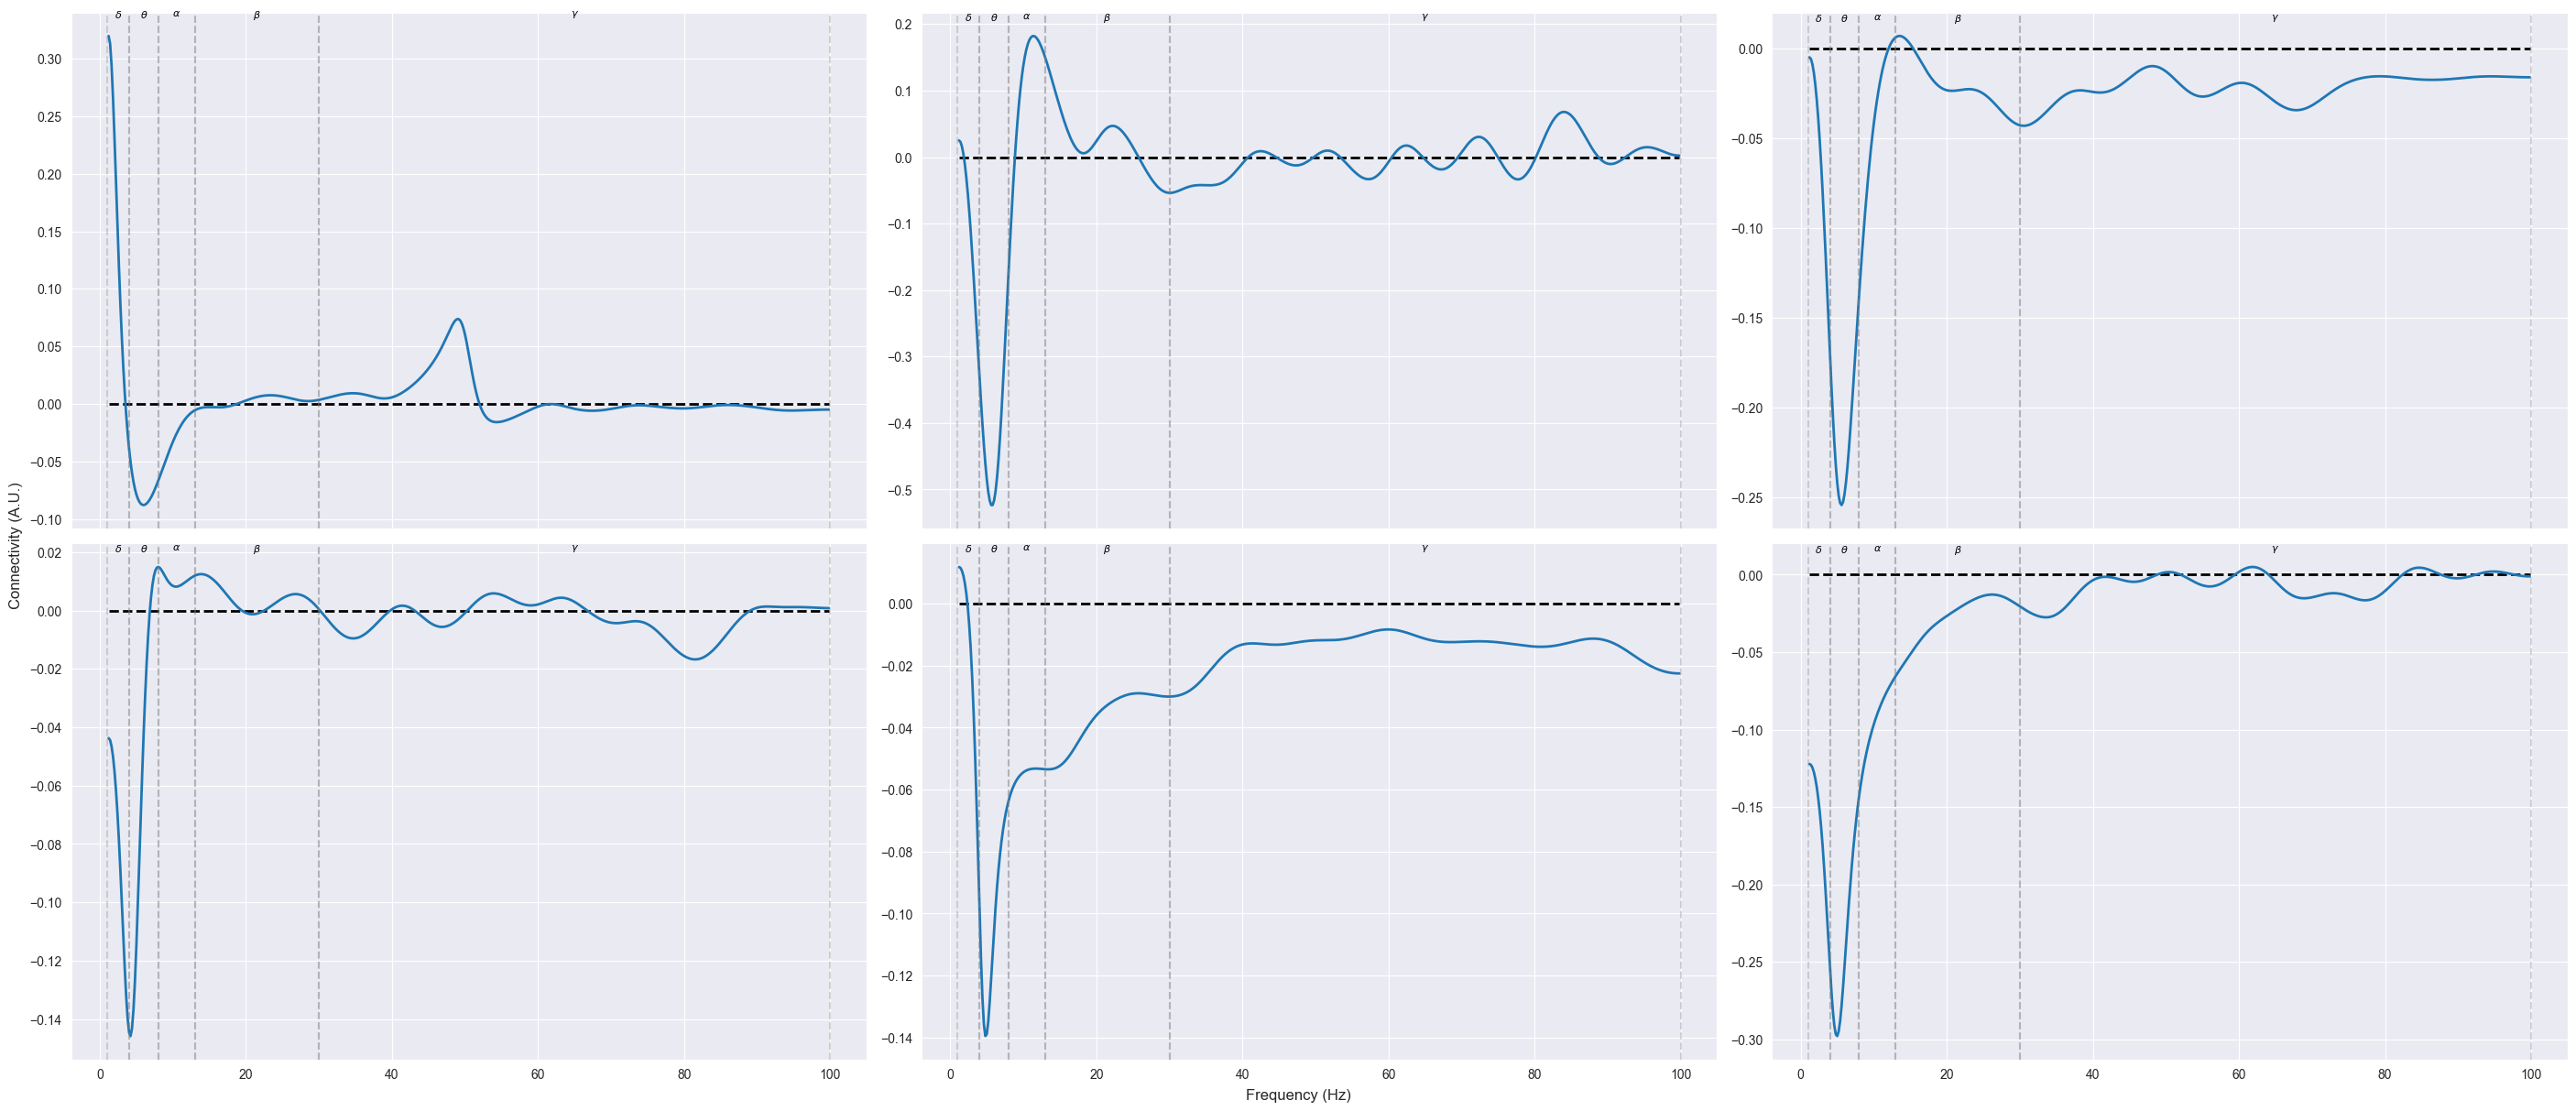

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(wt_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2)
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

Now we do the same for the KO subjects

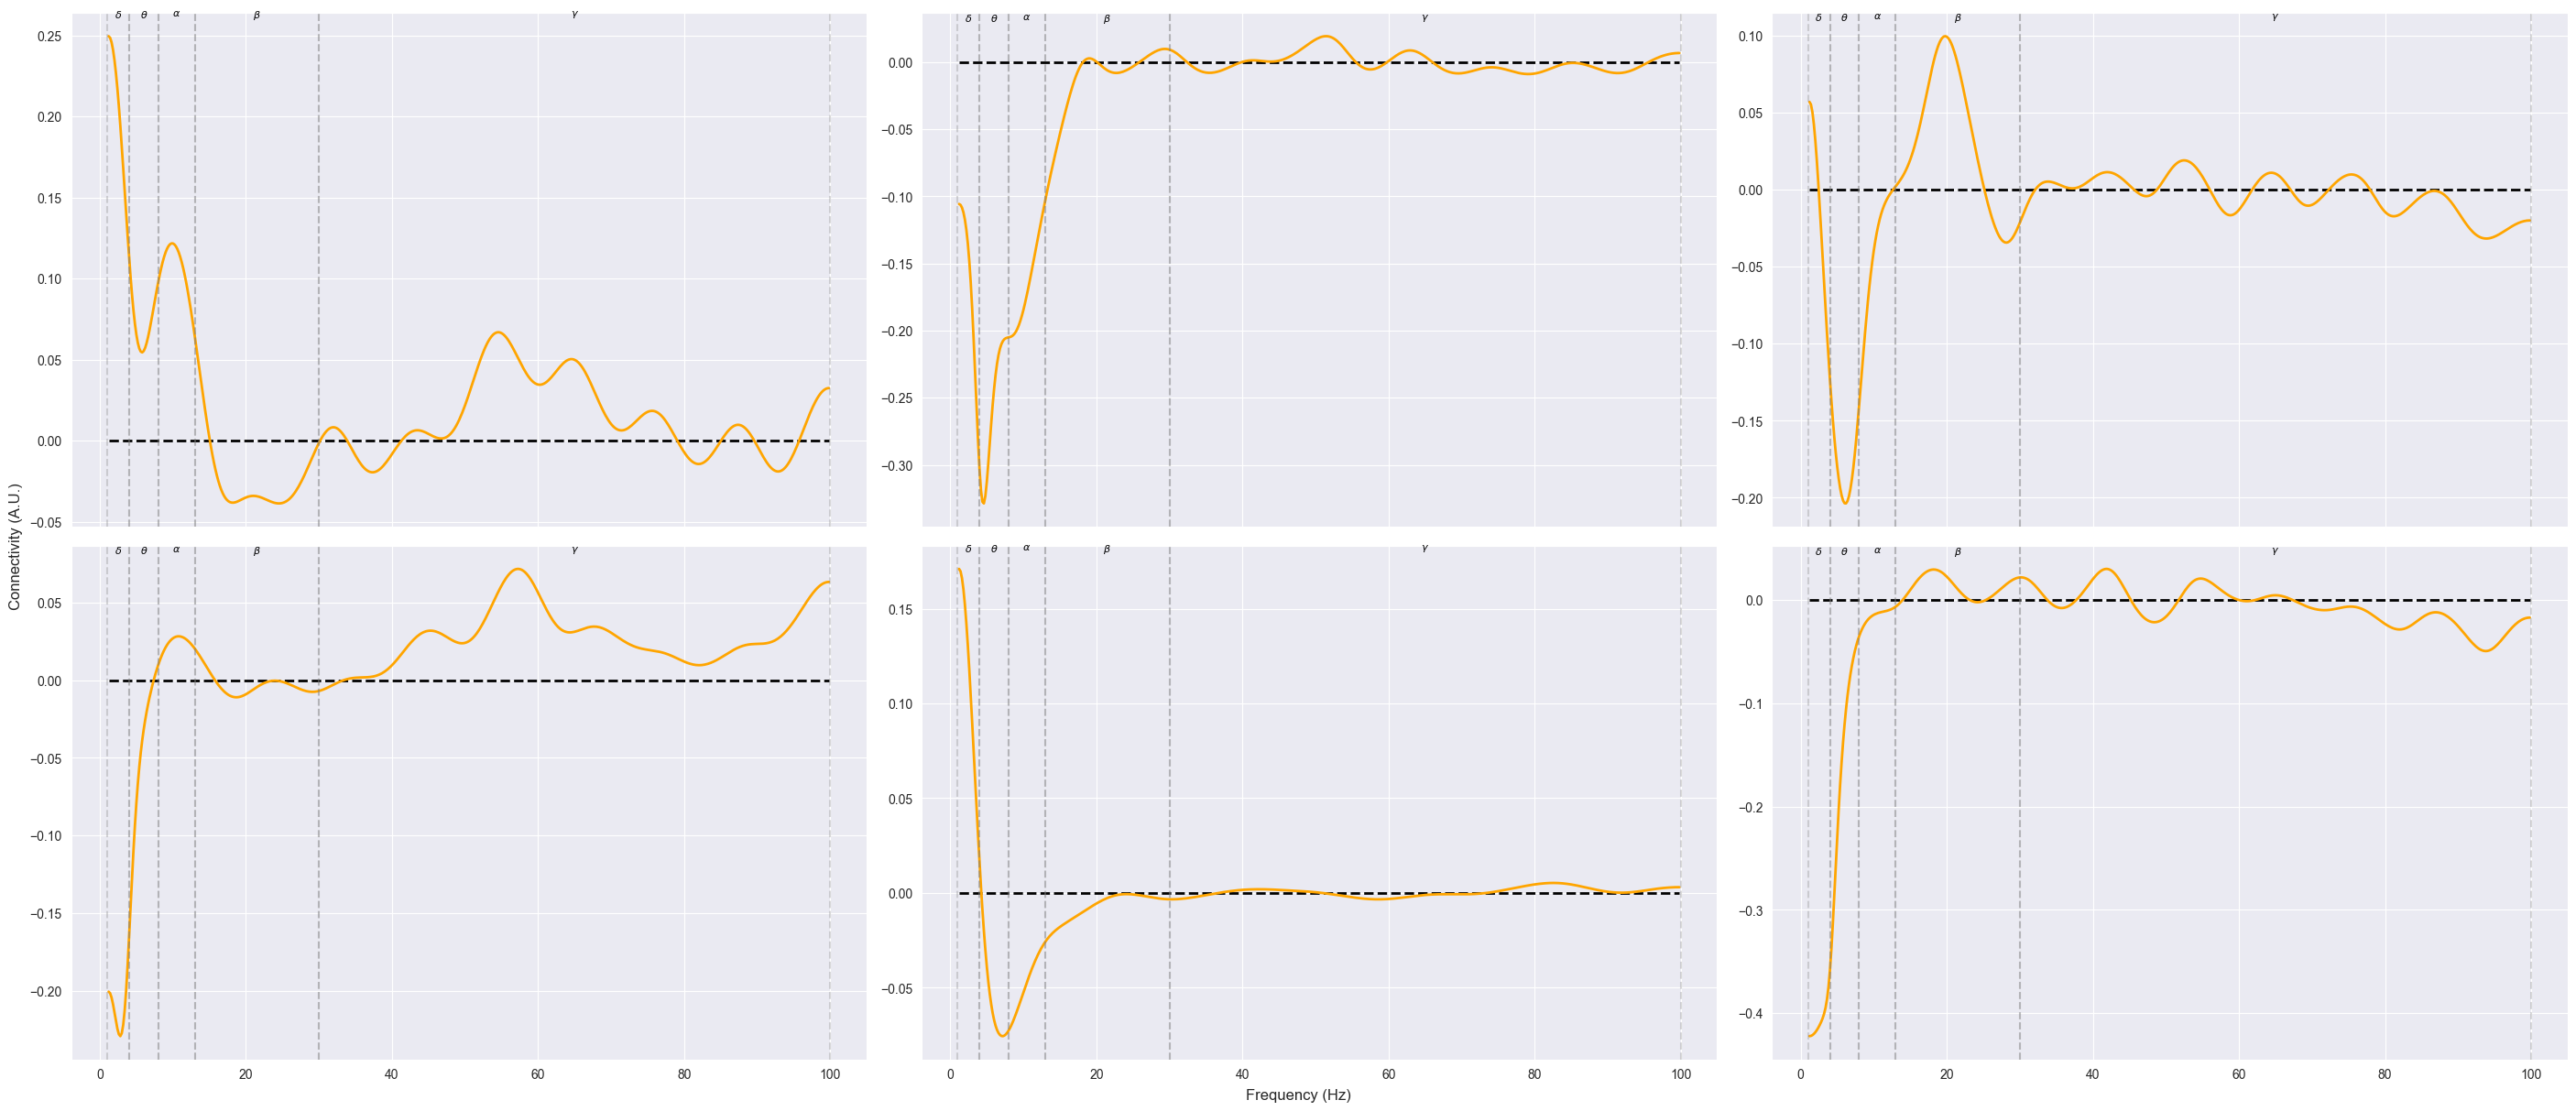

In [58]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(ko_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2, color='orange')
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

Let's average the TR-GC measures of all WT subjects, as well as all KO subjects

In [41]:
averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)

And now we plot the genotype averages

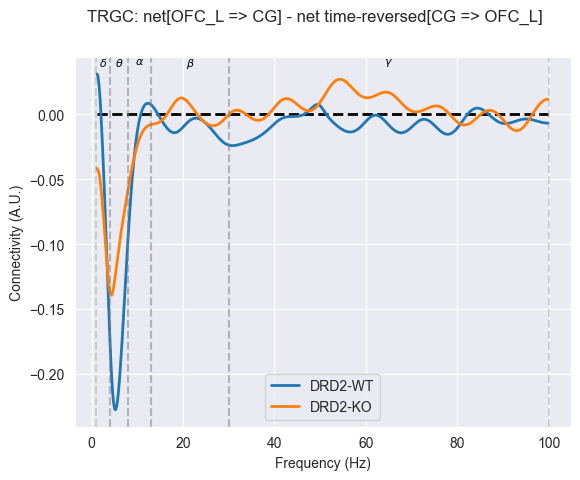

In [40]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT')
axis.plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO')
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[OFC_L => CG] - net time-reversed[OFC_L => CG]")
plt.legend()
plt.show()

Now, lets try two other channels

In [59]:
freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, picked_ids, "OFC_L", "STR_R")

Subject 79593 was not picked, skipping..
Subject 80625 was not picked, skipping..
Subject 39489 was not picked, skipping..
Subject 81193 was not picked, skipping..


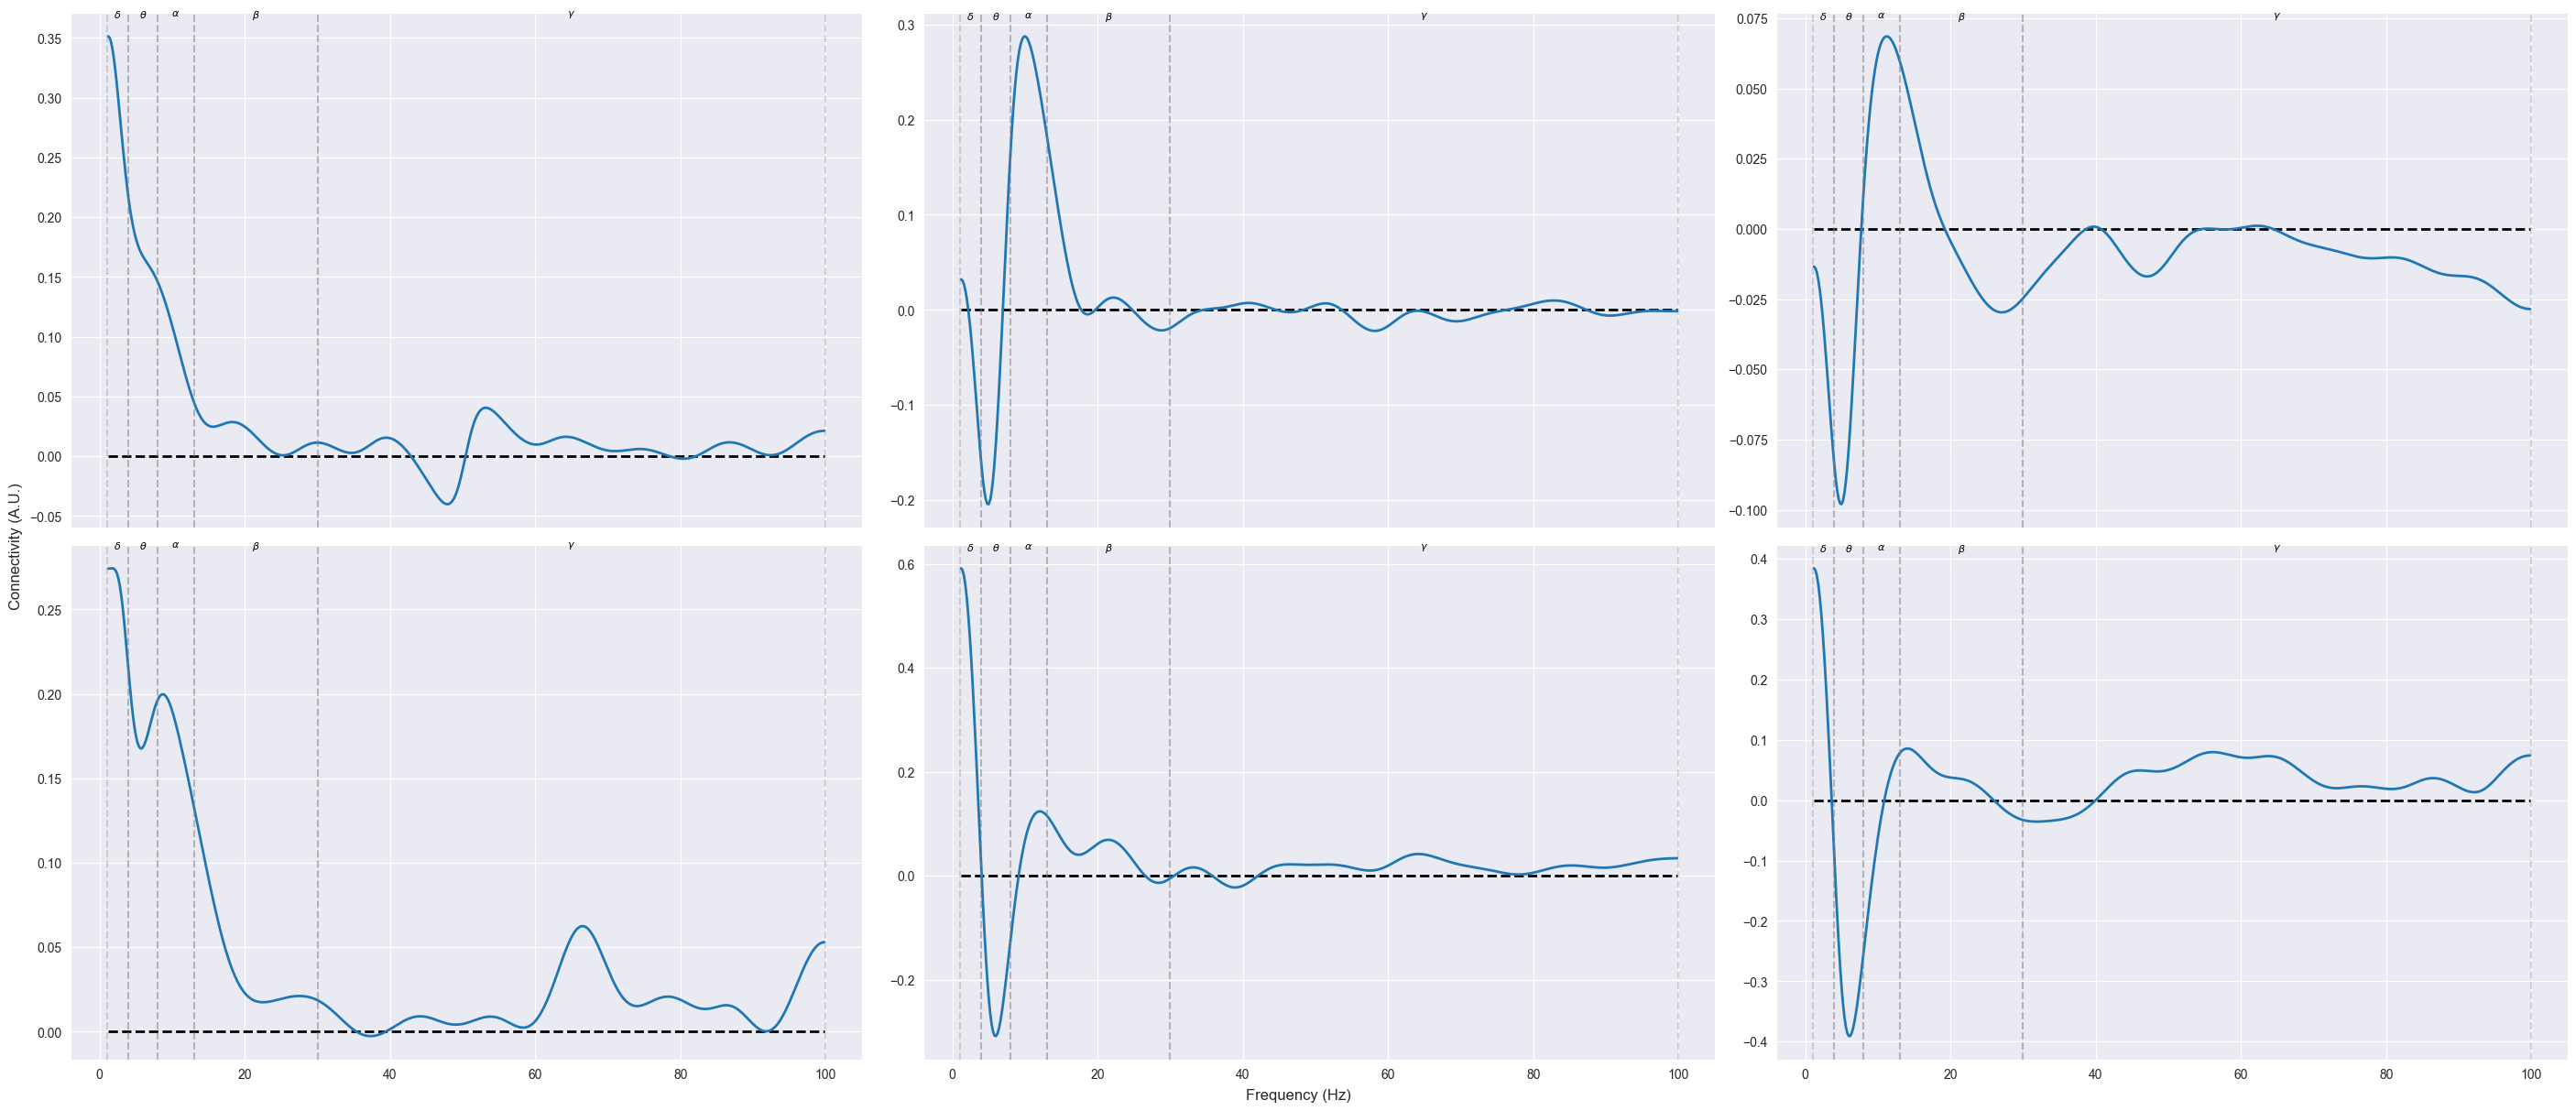

In [60]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(wt_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2)
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

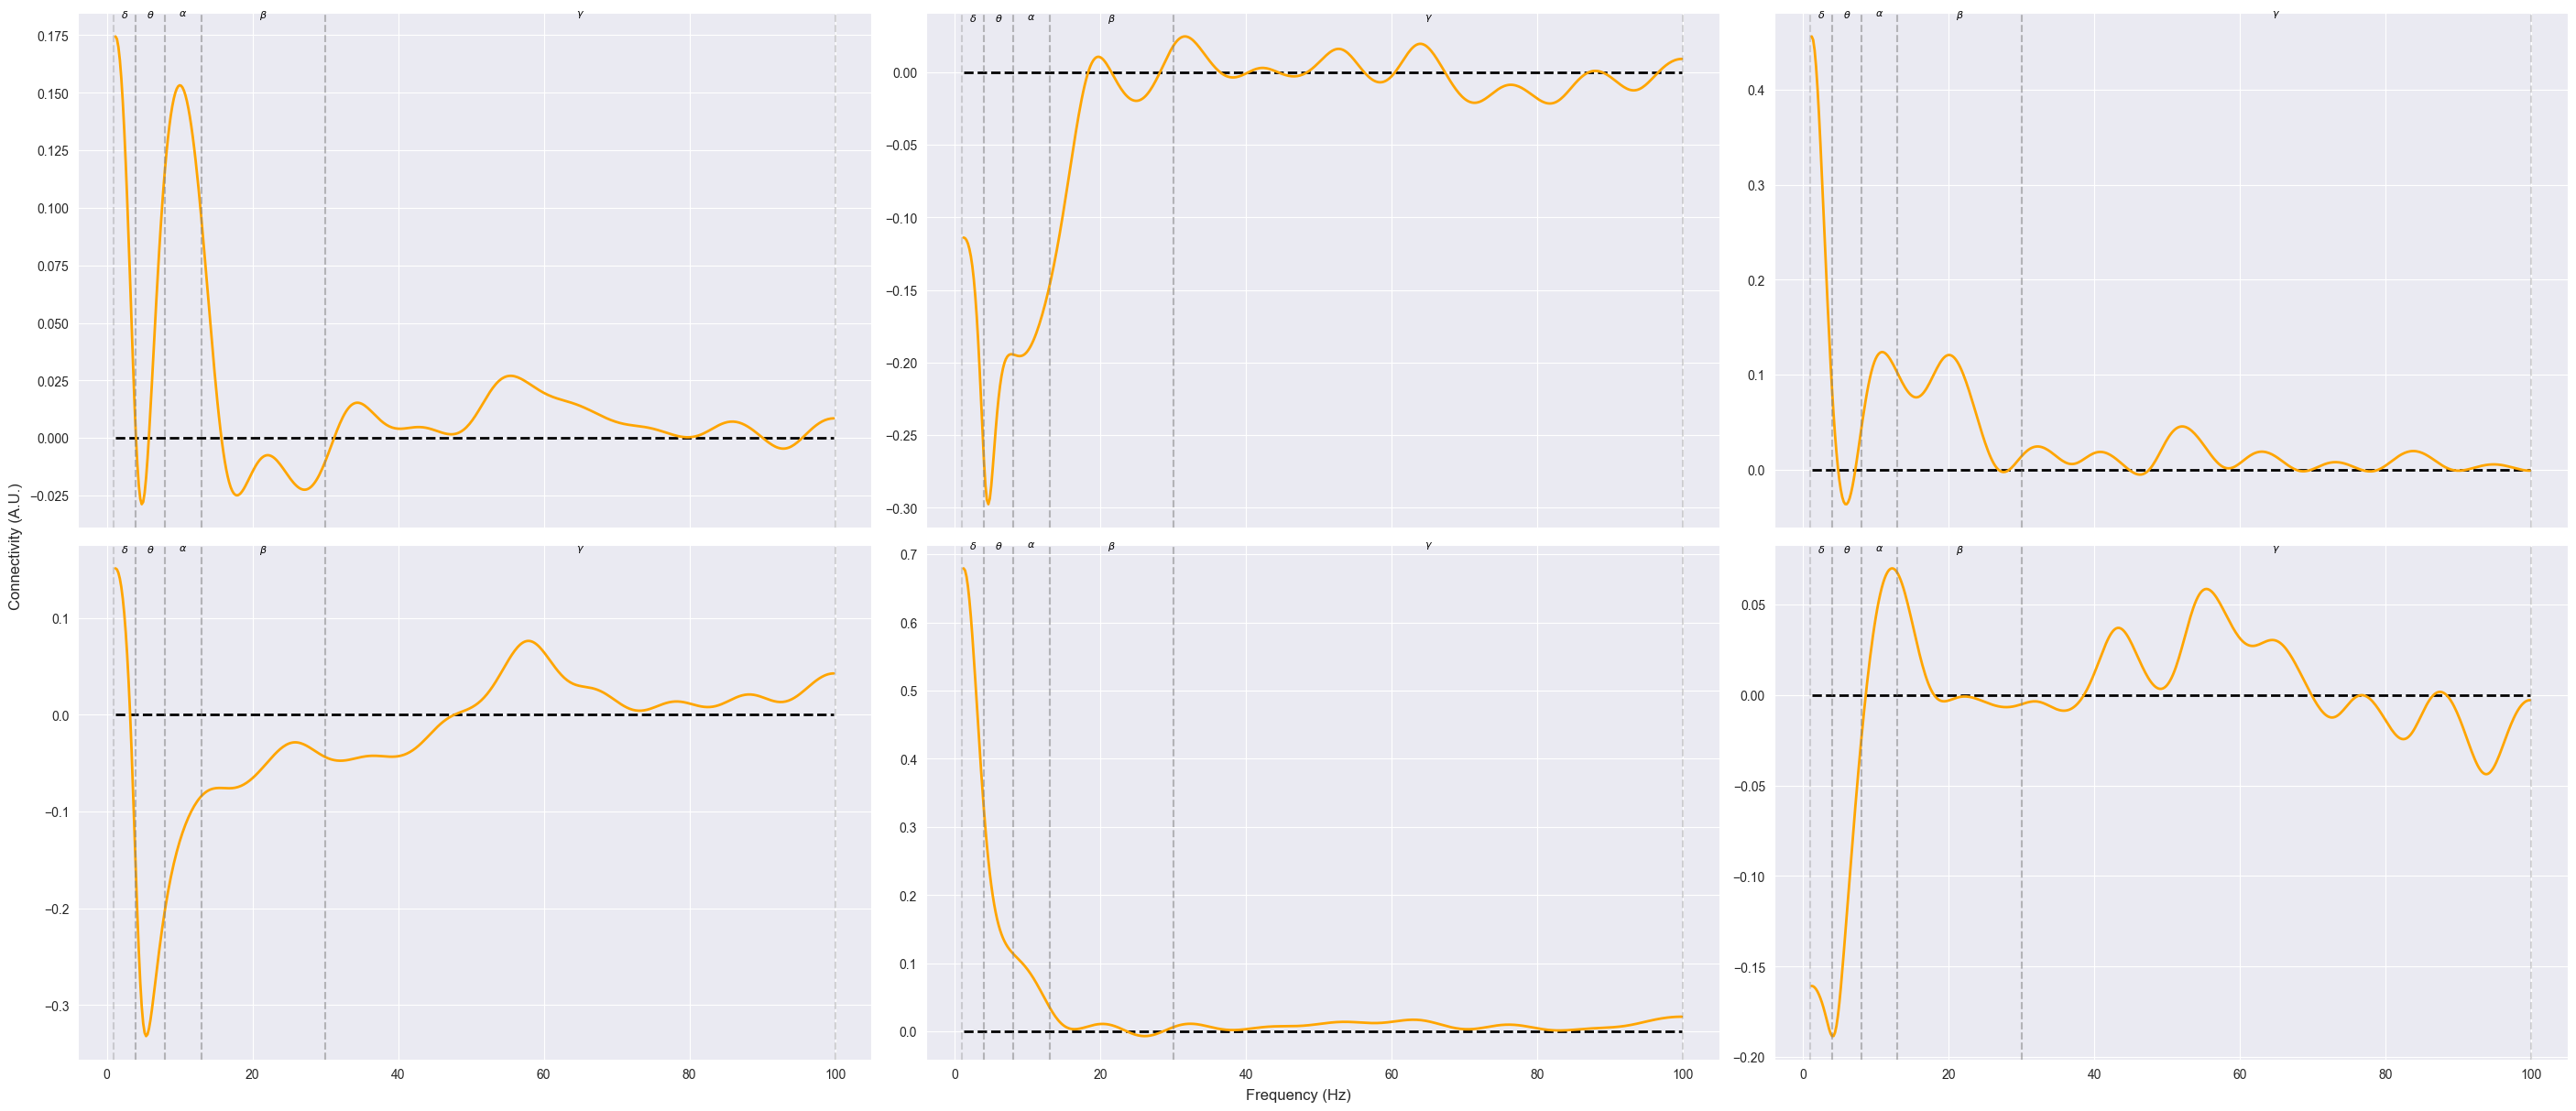

In [61]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(ko_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2, color='orange')
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

In [62]:
averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)

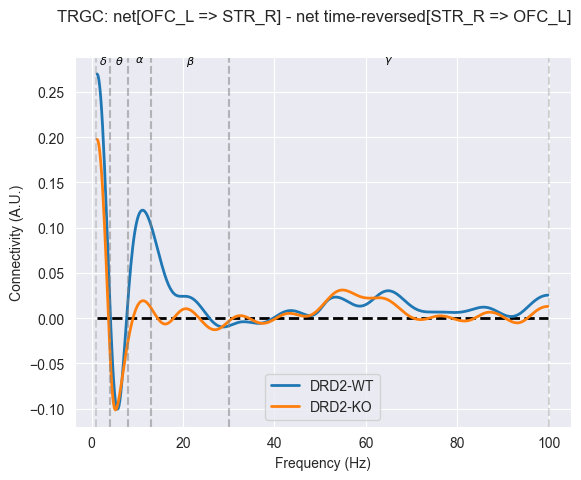

In [64]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT')
axis.plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO')
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[OFC_L => STR_R] - net time-reversed[OFC_L => STR_R]")
plt.legend()
plt.show()

In [65]:
freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, picked_ids, "CG", "STR_R")

Subject 79593 was not picked, skipping..
Subject 80625 was not picked, skipping..
Subject 39489 was not picked, skipping..
Subject 81193 was not picked, skipping..


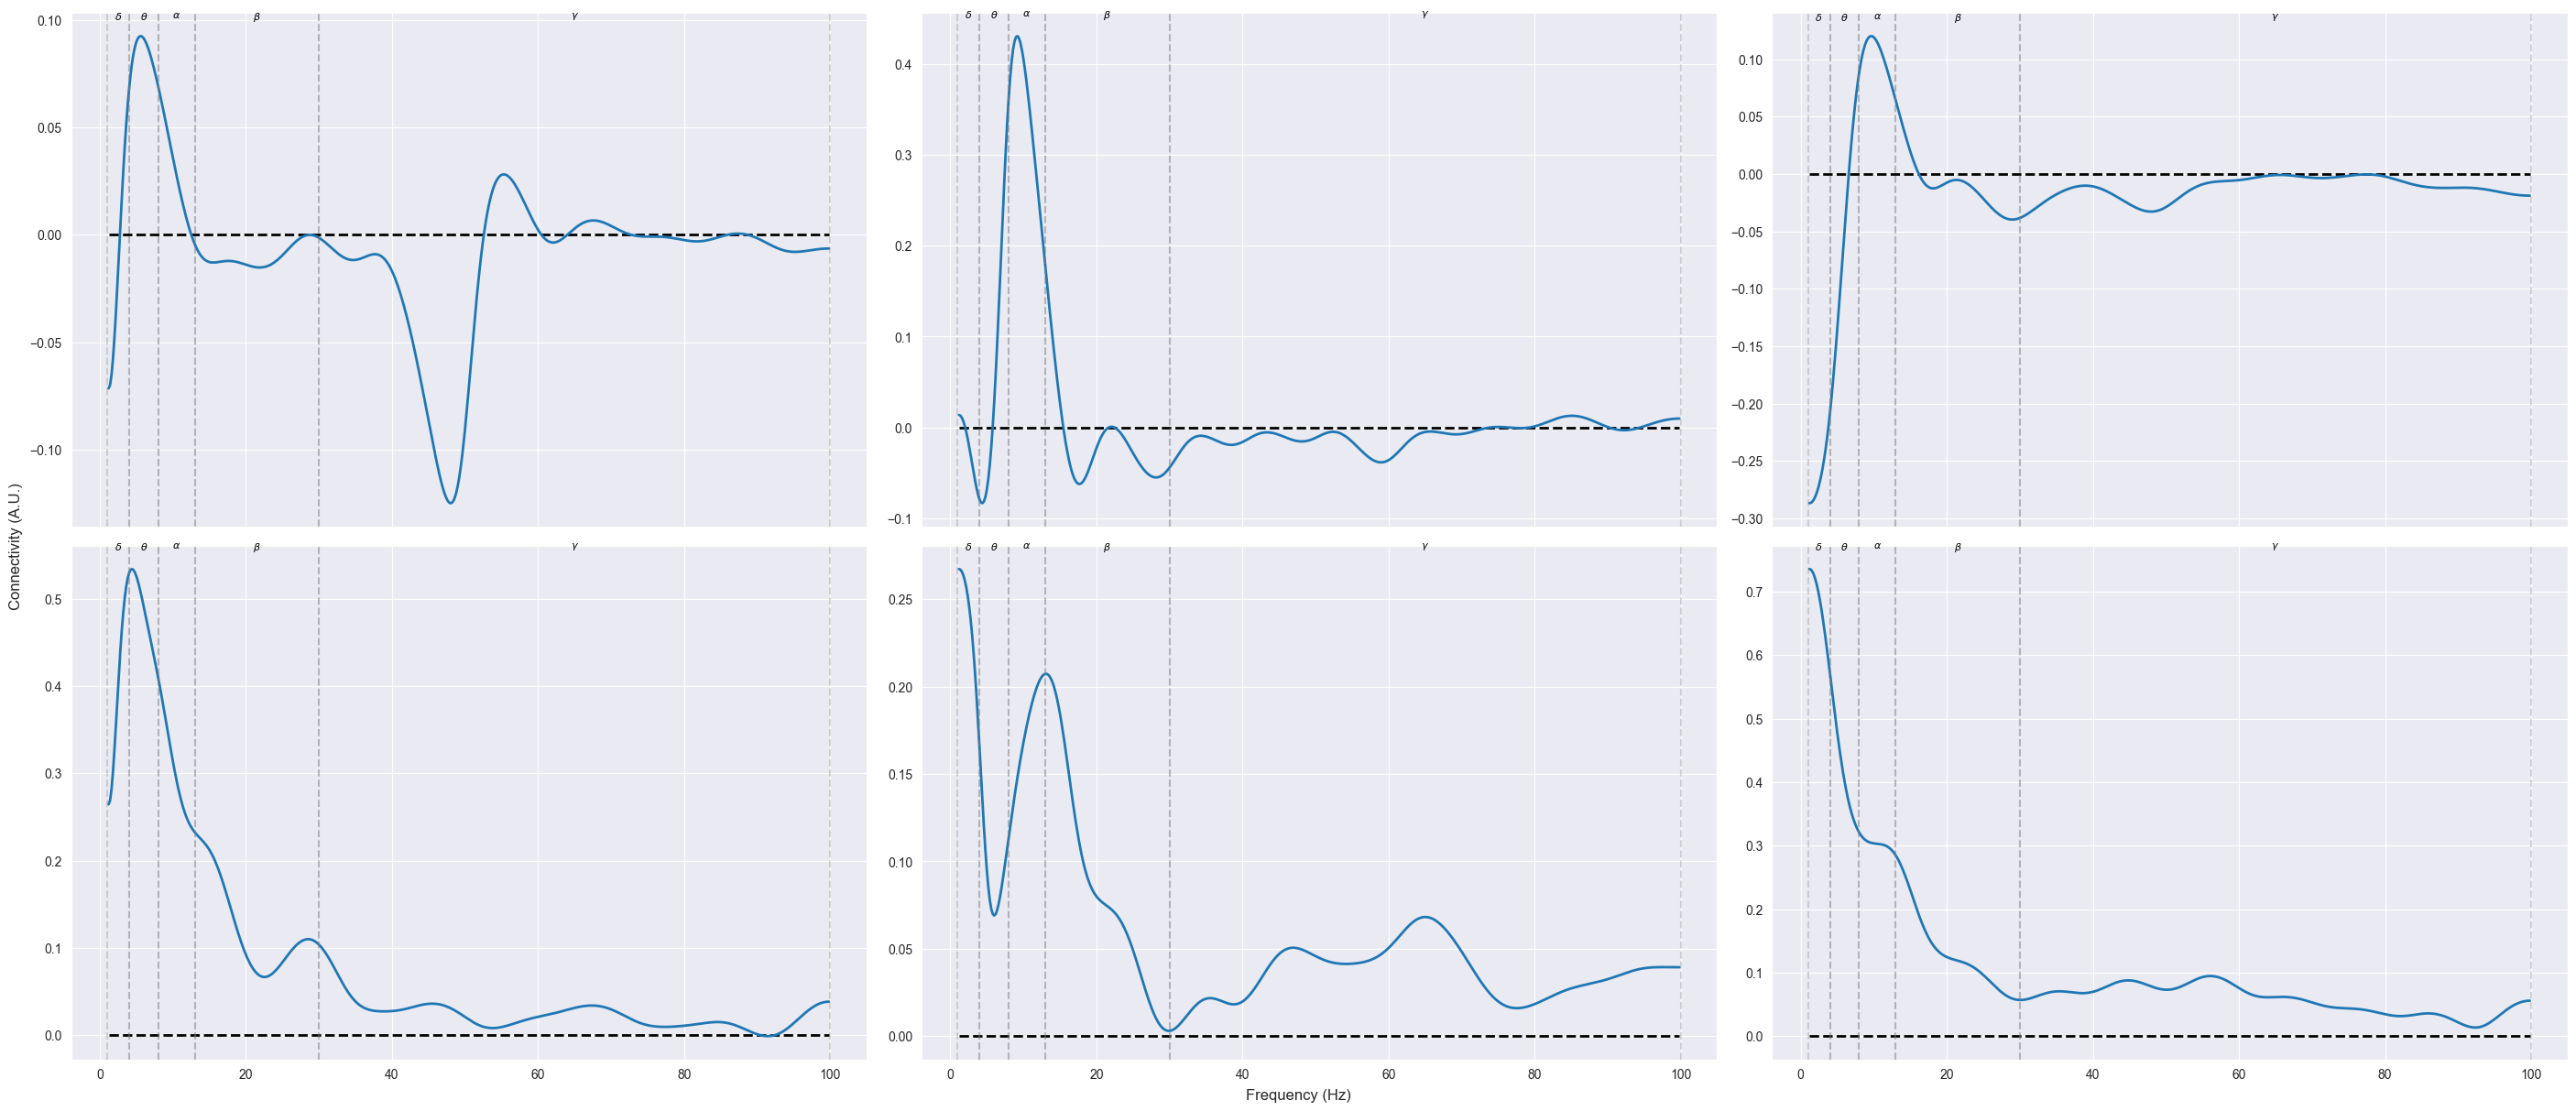

In [66]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(wt_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2)
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

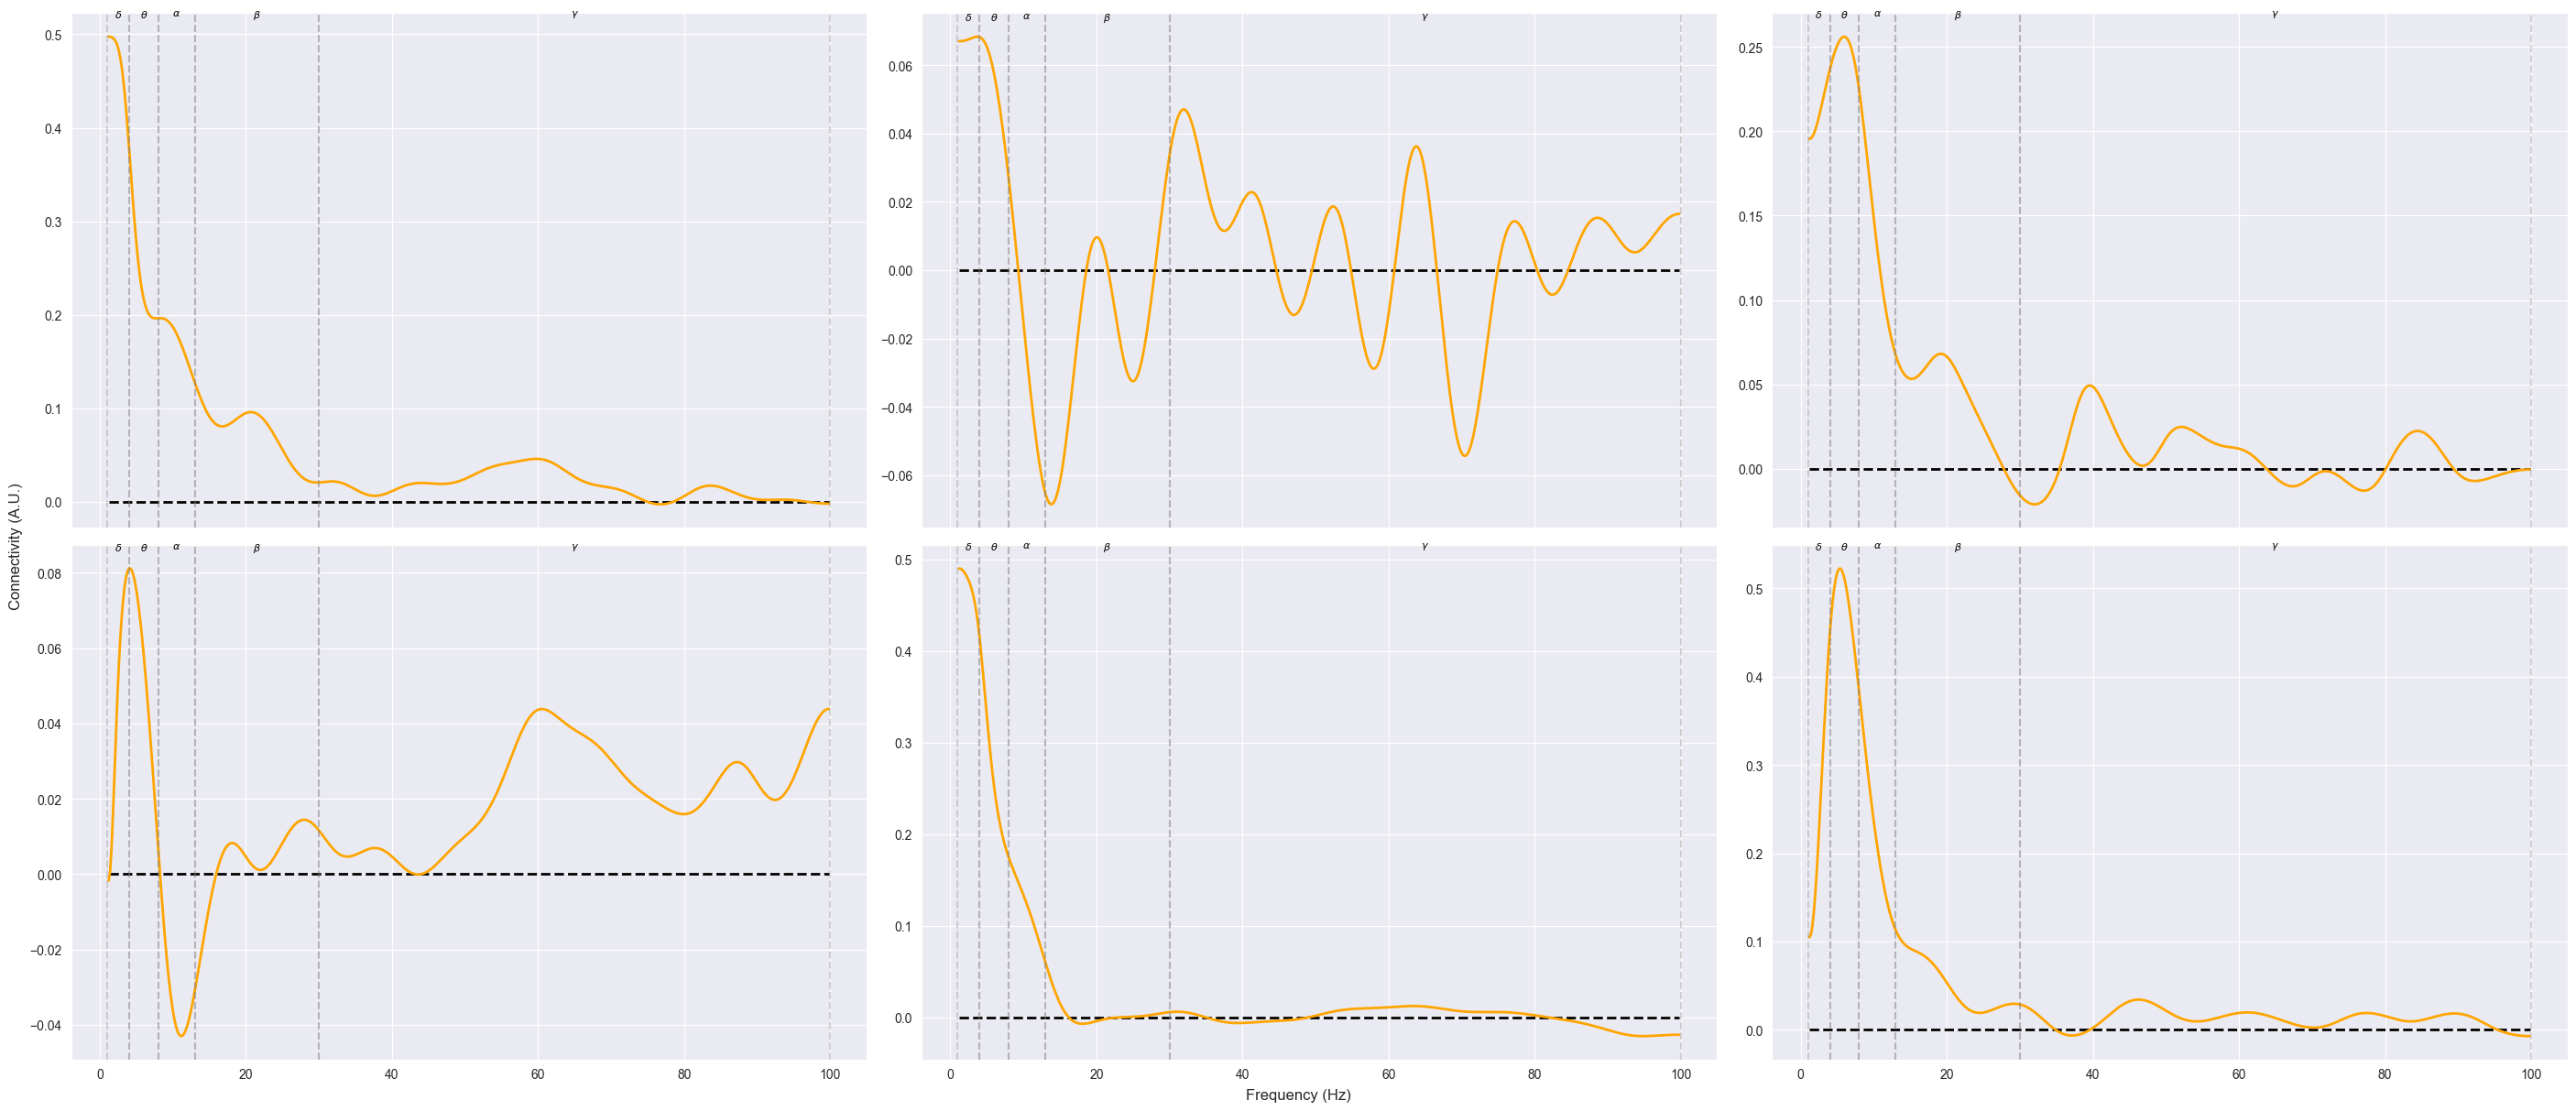

In [67]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(28, 12), sharex=True, sharey=True)
axs = axs.ravel()

for i, gc_trace in enumerate(ko_trgcs):
    axs[i].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
    axs[i].plot(freqs, gc_trace[0], linewidth=2, color='orange')
    for band, (start, end) in freq_bands_eeg.items():
        axs[i].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
        axs[i].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
        axs[i].text((start + end) / 2, axs[i].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

fig.text(0.5, 0, 'Frequency (Hz)', ha='center', va='center', fontsize=12)
fig.text(0, 0.5, 'Connectivity (A.U.)', ha='center', va='center', rotation='vertical', fontsize=12)
plt.tight_layout()
plt.show()

In [68]:
averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)

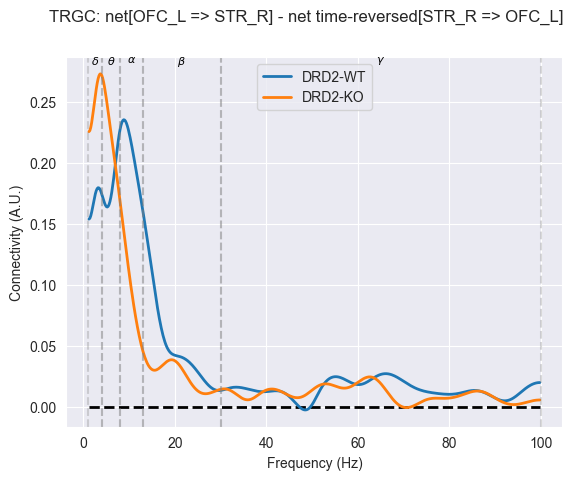

In [69]:
fig, axis = plt.subplots(1, 1)
axis.plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
axis.plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT')
axis.plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO')
for band, (start, end) in freq_bands_eeg.items():
    axis.axvline(x=start, color='gray', linestyle='--', alpha=0.3)
    axis.axvline(x=end, color='gray', linestyle='--', alpha=0.3)
    axis.text((start + end) / 2, axis.get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')

axis.set_xlabel("Frequency (Hz)")
axis.set_ylabel("Connectivity (A.U.)")
fig.suptitle(f"TRGC: net[OFC_L => STR_R] - net time-reversed[OFC_L => STR_R]")
plt.legend()
plt.show()

#### WT vs KO gridplot of averaged time-reversed Granger Causality

In [10]:
chans = all_subject_epochs[0].info['ch_names']
chans = [chan for chan in chans if chan not in excluded_chans]

fig, axs = plt.subplots(nrows=3, ncols=7, figsize=(35, 15), sharey=True, sharex=True)
axs = axs.ravel()

grid_index = 0
for i in range(len(chans)):
    for j in range(i + 1, len(chans)):
        freqs, wt_trgcs, ko_trgcs = get_tr_gc(all_subject_epochs, picked_ids, chans[i], chans[j])
        
        averaged_wt_trgcs = np.mean(wt_trgcs, axis=0)
        averaged_ko_trgcs = np.mean(ko_trgcs, axis=0)
        
        axs[grid_index].plot((freqs[0], freqs[-1]), (0, 0), linewidth=2, linestyle="--", color="k")
        axs[grid_index].plot(freqs, averaged_wt_trgcs[0], linewidth=2, label='DRD2-WT')
        axs[grid_index].plot(freqs, averaged_ko_trgcs[0], linewidth=2, label='DRD2-KO')
        axs[grid_index].legend()
        for band, (start, end) in freq_bands_eeg.items():
            axs[grid_index].axvline(x=start, color='gray', linestyle='--', alpha=0.3)
            axs[grid_index].axvline(x=end, color='gray', linestyle='--', alpha=0.3)
            axs[grid_index].text((start + end) / 2, axs[grid_index].get_ylim()[1] * 1.01, band, horizontalalignment='center', verticalalignment='top', fontsize=8, color='black')
        axs[grid_index].set_title(f'Time-reversed GC: net[{chans[i]} => {chans[j]}]')
        grid_index += 1

save_figure(os.path.join(plot_folder, f"resting_state/connectivity/TRGC_wt_vs_ko_grid.pdf"))